# Project Description
This notebook tries to solve mulit class emotion classification by using different machine learning models. We used Logistic Regression, Random Forest, SVM and LSTM (Long short-term memory). 

Research Question: ?

<b>Approach:</b><br>
First step was to remove duplicates, since some of them had also different labels. In our case I think this is fine, however if a model should predict multiple emotions of a text the duplicates should stay.<br>
Then we had a closer look at the data. We noticed that there were many stopwords in every text, which are not interesting for us. So we created a token column in each of our data sets and removed them. Afer that we used this token column to create a cleaned_text column. This column now only consists of the most important words of a sentence. <br>
We noticed heavy class imbalance among the train, test and validation set. For the classic machine learning approaches (Logistic Regression, Random Forest and SVM) we used SMOTE to balance the dataset. <br>
We decided to keep the data as it is for the deep learning model, because in our research about this topic class imbalance does not seem to be an issue for this approach (after evaluating it seemed like that but after a closer look with LIME I think there might be a bit of an issue 🥲 ).<br>
We used TfidfVectorizer to vectorize our text data and LabelEncoder for our Emotions (text to numbers so model can work with it).
Before then creating the models we scaled the data to hopefully get better results.<br>

why we chose those models + sources

The way we approached the classic machine learning models was pretty similar to each other. First we created a Grid search to find the best parameters, after that we created the model with those found values. We created a custom function that evaluates each model. Then we save them (learned this lesson after losing my LSTM model from a pc crash).

<b>Results:</b><br>
At the end of the notebook is a section that compares the models. The best one seems to be the LSTM model, however due to imbalanced dataset (overfitting) some sentences which seem clear to be a certain emotion fail to be recognized. In doubt the model seems to pivot to "joy", because of the huge difference between the data points. 

<b>Conclusion:</b><br>
For the future, I would always try to solve a task like this with deep learning algorithms. They seem to perform way better, but are very complex and hard to understand. 
Using SHAP was really complicated for me. I tried it for quite some time and somewhat made it work with the Logistic Regression Model, however due to the long time it took to compile I chose LIME to explain the LSTM model. 




# Imports

In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import string
import shap
import pickle

from imblearn.over_sampling import SMOTE

from wordcloud import WordCloud

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding
from keras.optimizers import Adam
from keras.layers import Bidirectional
from keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional
from tensorflow.keras.models import load_model

from lime.lime_text import LimeTextExplainer

#nltk.download('stopwords')
#nltk.download('punkt_tab')

## Importing Data
<b>Train</b>, <b>Test</b>, <b>Val</b> sets are imported from CSV-File and merged into <b>data</b>. <br>
<b>Train, test, val</b> will be used for EDA and modelling, while <b>data</b> is only used to visiualize overall biases/issues of the dataset.

In [25]:
model = load_model("model_lstm.h5")

In [2]:
train = pd.read_csv('train.txt', names=['Text', 'Emotion'], sep=';')
test = pd.read_csv('test.txt', names=['Text', 'Emotion'], sep=';')
val = pd.read_csv('val.txt', names=['Text', 'Emotion'], sep=';')

data = pd.concat([train, test, val])
data.reset_index(inplace=True, drop=True)

In [3]:
stop_words = set(stopwords.words('english'))  # English stopwords

# EDA
Visiualizing the dataset, checking for issues, ...

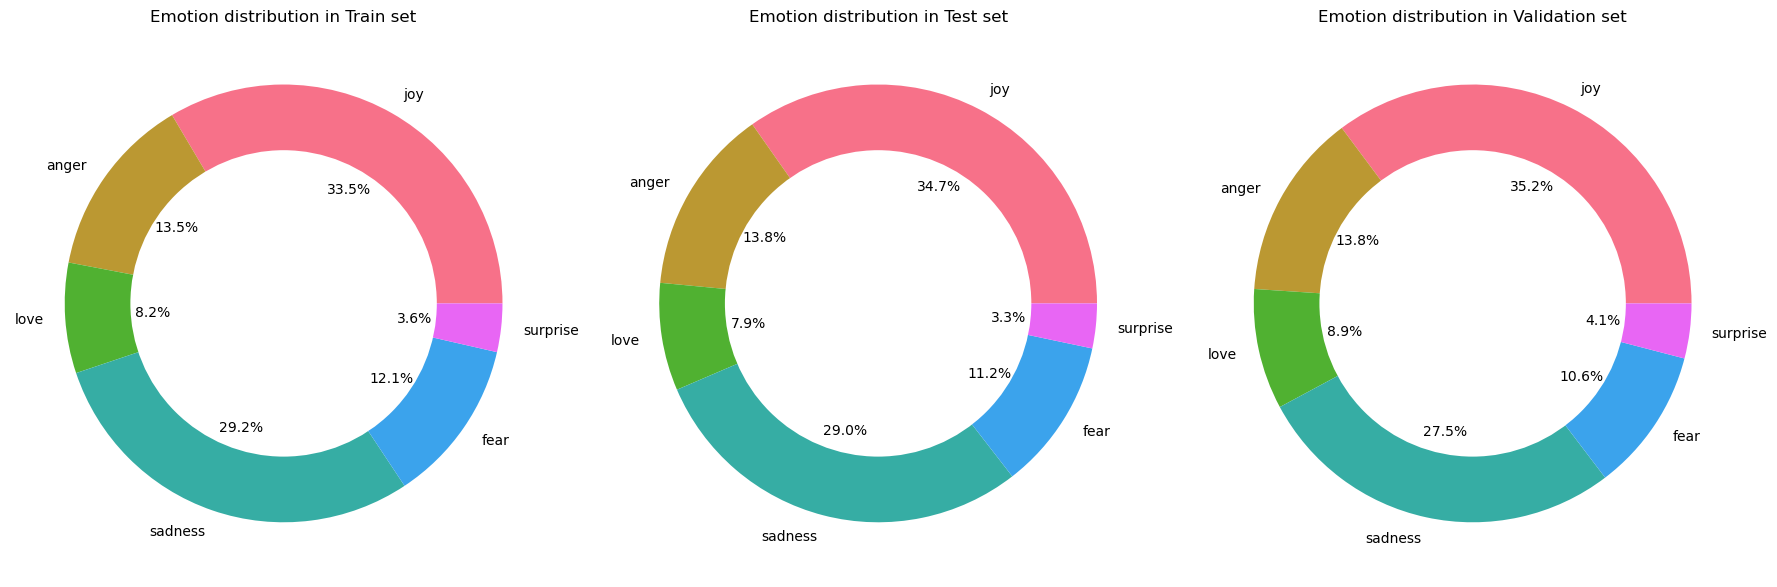

In [4]:
# Labels, sizes, and colors
labels = ["joy", "anger", "love", "sadness", "fear", "surprise"]
colors = sns.color_palette("husl", len(labels))

# Sizes for Train, Test, and Validation sets
sizes_train = [train['Emotion'].value_counts()[label] for label in labels]
sizes_test = [test['Emotion'].value_counts()[label] for label in labels]
sizes_val = [val['Emotion'].value_counts()[label] for label in labels]

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Train set pie chart
axes[0].pie(sizes_train, labels=labels, autopct='%1.1f%%', colors=colors, startangle=0)
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
axes[0].add_artist(centre_circle)
axes[0].set_title('Emotion distribution in Train set')

# Test set pie chart
axes[1].pie(sizes_test, labels=labels, autopct='%1.1f%%', colors=colors, startangle=0)
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
axes[1].add_artist(centre_circle)
axes[1].set_title('Emotion distribution in Test set')

# Validation set pie chart
axes[2].pie(sizes_val, labels=labels, autopct='%1.1f%%', colors=colors, startangle=0)
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
axes[2].add_artist(centre_circle)
axes[2].set_title('Emotion distribution in Validation set')

# Adjust layout and display the chart
plt.tight_layout()
plt.show()

## Comparing the Train, Test and Validation sets

### Checking the distribution of the classes

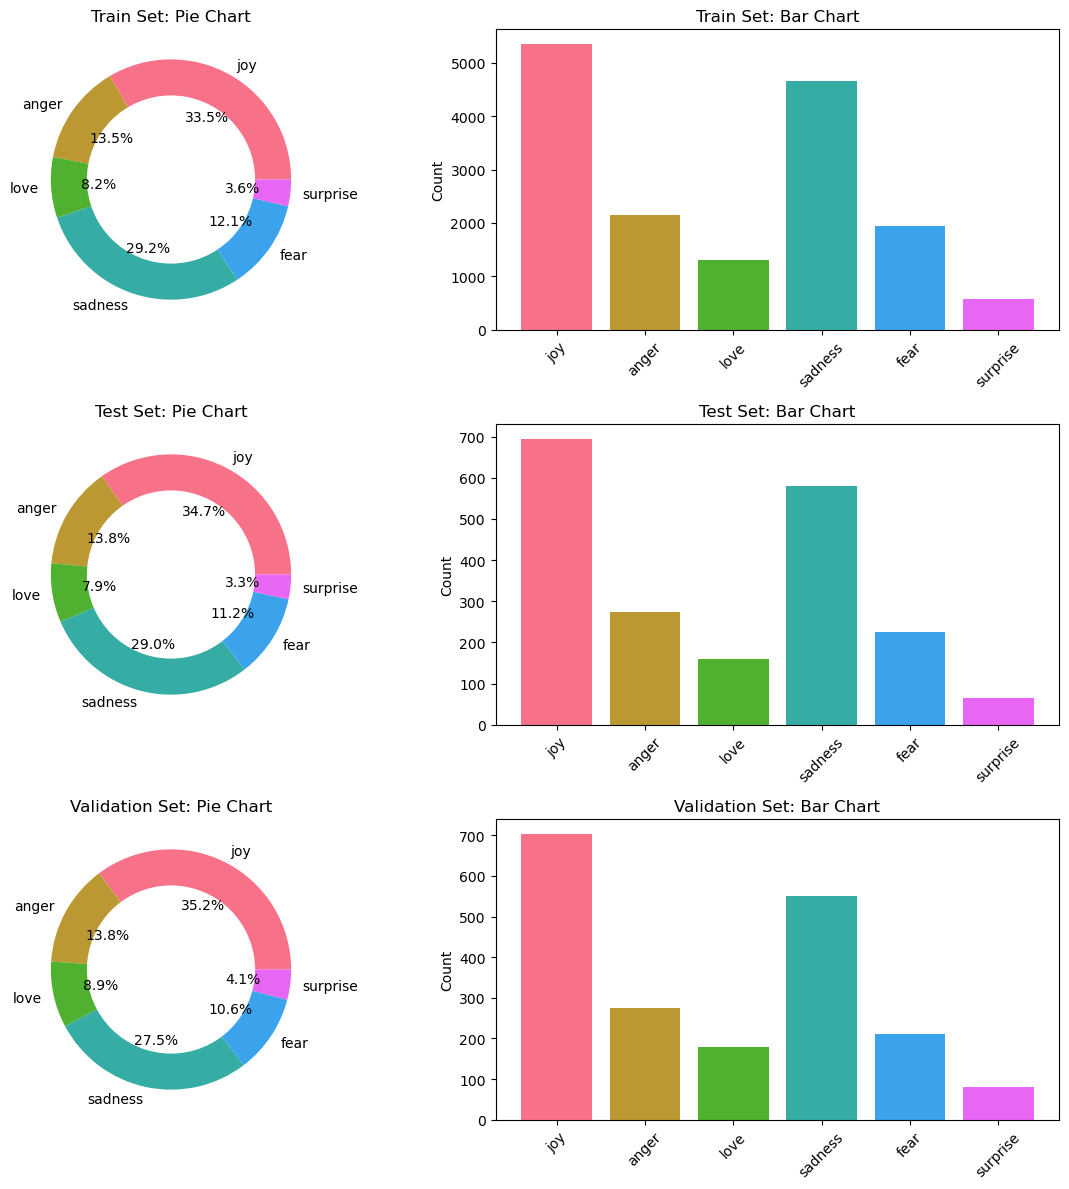

In [5]:
# Labels, sizes, and colors
labels = ["joy", "anger", "love", "sadness", "fear", "surprise"]
colors = sns.color_palette("husl", len(labels))

# Sizes for Train, Test, and Validation sets
sizes_train = [train['Emotion'].value_counts()[label] for label in labels]
sizes_test = [test['Emotion'].value_counts()[label] for label in labels]
sizes_val = [val['Emotion'].value_counts()[label] for label in labels]

# Create subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 12))  # 3 rows (datasets), 2 columns (pie and bar charts)

# Train set
# Pie Chart
axes[0, 0].pie(sizes_train, labels=labels, autopct='%1.1f%%', colors=colors, startangle=0)
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
axes[0, 0].add_artist(centre_circle)
axes[0, 0].set_title('Train Set: Pie Chart')

# Bar Chart
axes[0, 1].bar(labels, sizes_train, color=colors)
axes[0, 1].set_title('Train Set: Bar Chart')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_xticks(range(len(labels)))
axes[0, 1].set_xticklabels(labels, rotation=45)

# Test set
# Pie Chart
axes[1, 0].pie(sizes_test, labels=labels, autopct='%1.1f%%', colors=colors, startangle=0)
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
axes[1, 0].add_artist(centre_circle)
axes[1, 0].set_title('Test Set: Pie Chart')

# Bar Chart
axes[1, 1].bar(labels, sizes_test, color=colors)
axes[1, 1].set_title('Test Set: Bar Chart')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_xticks(range(len(labels)))
axes[1, 1].set_xticklabels(labels, rotation=45)

# Validation set
# Pie Chart
axes[2, 0].pie(sizes_val, labels=labels, autopct='%1.1f%%', colors=colors, startangle=0)
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
axes[2, 0].add_artist(centre_circle)
axes[2, 0].set_title('Validation Set: Pie Chart')

# Bar Chart
axes[2, 1].bar(labels, sizes_val, color=colors)
axes[2, 1].set_title('Validation Set: Bar Chart')
axes[2, 1].set_ylabel('Count')
axes[2, 1].set_xticks(range(len(labels)))
axes[2, 1].set_xticklabels(labels, rotation=45)

# Adjust layout and display the charts
plt.tight_layout()
plt.show()

### Comparing Text Length with Emotion

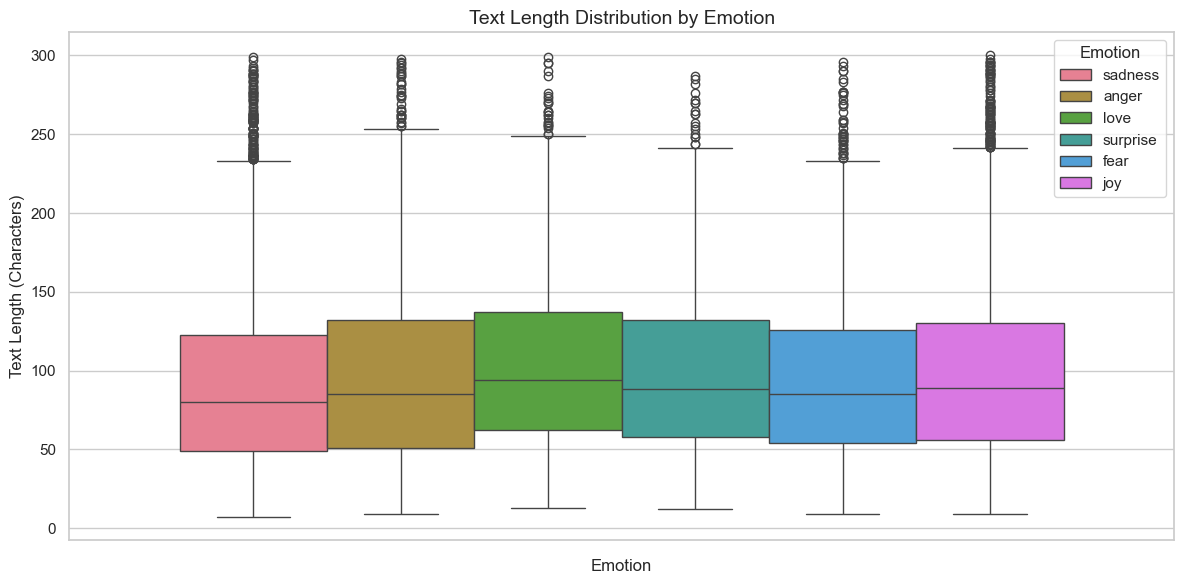

In [6]:
# Set the plot style
sns.set(style="whitegrid")

# Create a boxplot for text length by emotion
plt.figure(figsize=(12, 6))
sns.boxplot(data=train, hue='Emotion', y=train['Text'].apply(len), palette="husl")

# Add title and labels
plt.title('Text Length Distribution by Emotion', fontsize=14)
plt.xlabel('Emotion', fontsize=12)
plt.ylabel('Text Length (Characters)', fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()

### Wordcloud
Checking which words appear the most in what class(emotion). We removed all the stopwords and words like feeling or feel since they are the most used in every emotion and don't mean alot.

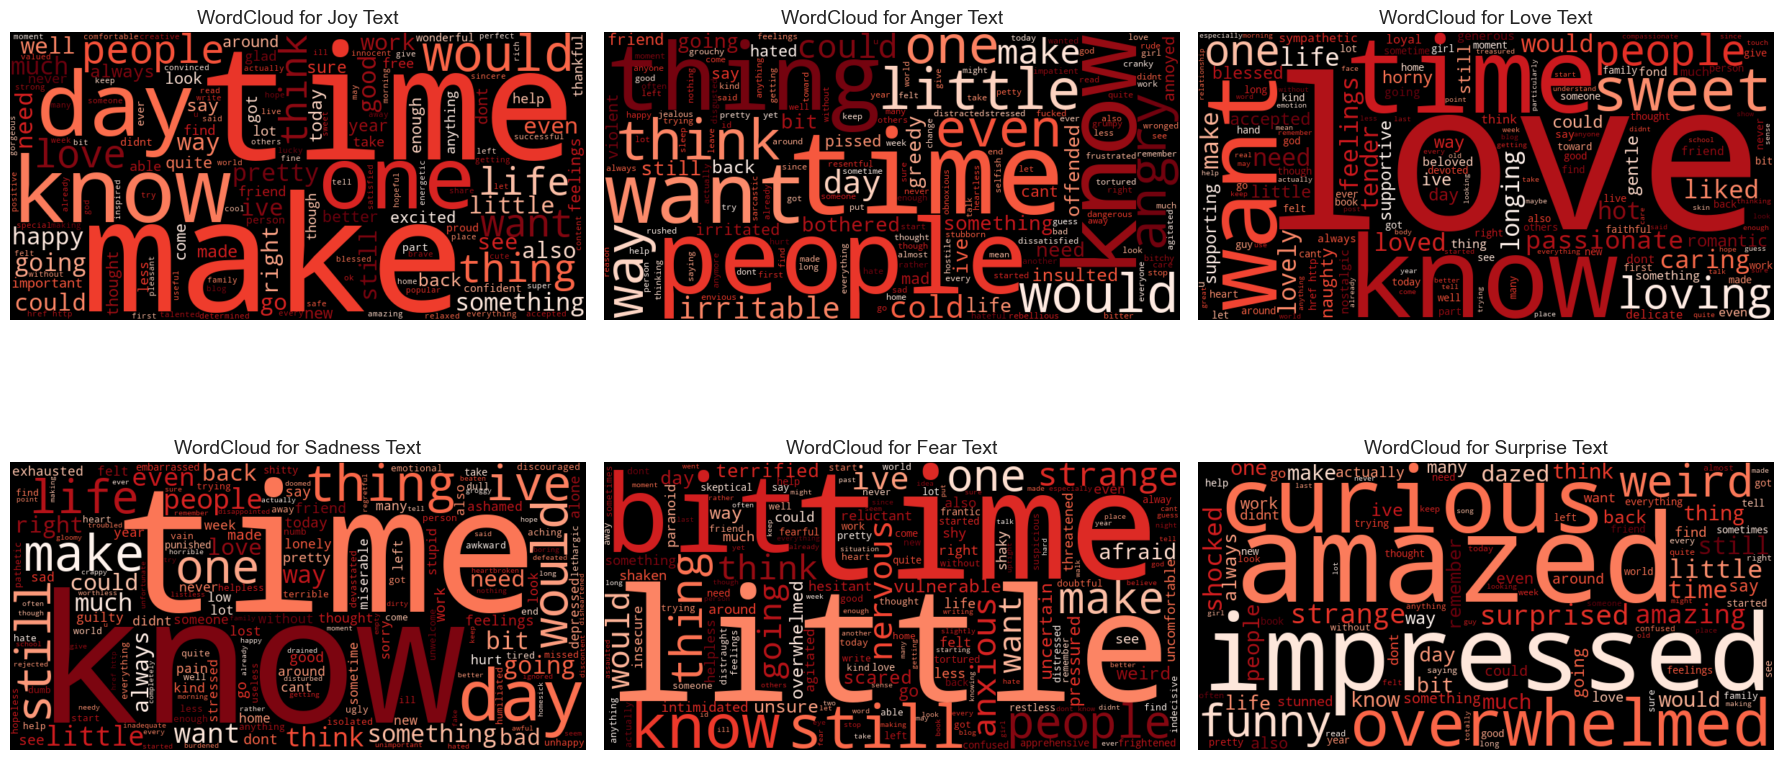

In [7]:
custom_stopwords = set(stopwords.words('english')) | {'feel', 'feeling', 'feels', 'like', 'im', 'really', 'get'}

# Initialize WordCloud object
wordcloud = WordCloud(
    width=800, 
    height=400, 
    min_font_size=10, 
    background_color='black', 
    colormap='Reds',
    stopwords=custom_stopwords
)

# Labels and their corresponding colors
emotions = ["joy", "anger", "love", "sadness", "fear", "surprise"]
colormaps = ['Reds', 'Blues', 'Greens', 'Purples', 'Oranges', 'cool']

# Create a figure for subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 2 rows, 3 columns

# Loop through each emotion and plot the word cloud
for i, (emotion, colormap) in enumerate(zip(emotions, colormaps)):
    ax = axes[i // 3, i % 3]  # Determine subplot position

    # Generate the word cloud for the emotion
    emotion_wordcloud = wordcloud.generate(data[data['Emotion'] == emotion]['Text'].str.cat(sep=" "))

    # Plot the word cloud
    ax.imshow(emotion_wordcloud, interpolation='bilinear')
    ax.set_title(f"WordCloud for {emotion.capitalize()} Text", fontsize=14)
    ax.axis('off')  # Remove axes for better appearance

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

### Checking for duplicates

In [4]:
# Before removing duplicates, print the count of duplicates
train_duplicates_before = train[train.duplicated(subset=["Text"], keep=False)].shape[0]
test_duplicates_before = test[test.duplicated(subset=["Text"], keep=False)].shape[0]
val_duplicates_before = val[val.duplicated(subset=["Text"], keep=False)].shape[0]

print(f"Before removing duplicates - train duplicates: {train_duplicates_before}")
print(f"Before removing duplicates - test duplicates: {test_duplicates_before}")
print(f"Before removing duplicates - val duplicates: {val_duplicates_before}")

# Remove duplicates from the datasets
train.drop_duplicates(subset=["Text"], keep='first', inplace=True)
test.drop_duplicates(subset=["Text"], keep='first', inplace=True)
val.drop_duplicates(subset=["Text"], keep='first', inplace=True)

# After removing duplicates, print the count of duplicates again
train_duplicates_after = train[train.duplicated(subset=["Text"], keep=False)].shape[0]
test_duplicates_after = test[test.duplicated(subset=["Text"], keep=False)].shape[0]
val_duplicates_after = val[val.duplicated(subset=["Text"], keep=False)].shape[0]

print(f"After removing duplicates - train duplicates: {train_duplicates_after}")
print(f"After removing duplicates - test duplicates: {test_duplicates_after}")
print(f"After removing duplicates - val duplicates: {val_duplicates_after}")

Before removing duplicates - train duplicates: 62
Before removing duplicates - test duplicates: 0
Before removing duplicates - val duplicates: 4
After removing duplicates - train duplicates: 0
After removing duplicates - test duplicates: 0
After removing duplicates - val duplicates: 0


# Modelling

## Tokenizing, Vectorizing and Labeling

Adding a token column to the existing dataframes. This column will then be used to train the model. Removing stopwords aswell.

In [5]:
train['token'] = train['Text'].apply(word_tokenize)
test['token'] = test['Text'].apply(word_tokenize)
val['token'] = val['Text'].apply(word_tokenize)

In [6]:
stop_words = set(stopwords.words('english'))

def remove_stop_words(tokens):
    return [word for word in tokens if word.lower() not in stop_words]

train['token'] = train['token'].apply(remove_stop_words)
test['token'] = test['token'].apply(remove_stop_words)
val['token'] = val['token'].apply(remove_stop_words)

In [7]:
train.head()

,Text,Emotion,token
0,i didnt feel humiliated,sadness,"[didnt, feel, humiliated]"
1,i can go from feeling so hopeless to so damned...,sadness,"[go, feeling, hopeless, damned, hopeful, aroun..."
2,im grabbing a minute to post i feel greedy wrong,anger,"[im, grabbing, minute, post, feel, greedy, wrong]"
3,i am ever feeling nostalgic about the fireplac...,love,"[ever, feeling, nostalgic, fireplace, know, st..."
4,i am feeling grouchy,anger,"[feeling, grouchy]"


In [8]:
def tokens_to_text(tokens):
    return ' '.join(tokens)

# Apply this function to the 'token' column to create a new 'Text' column with cleaned text
train['cleaned_text'] = train['token'].apply(tokens_to_text)
test['cleaned_text'] = test['token'].apply(tokens_to_text)
val['cleaned_text'] = val['token'].apply(tokens_to_text)

# Check the result
print(train.head())

                                                Text  Emotion  \
0                            i didnt feel humiliated  sadness   
1  i can go from feeling so hopeless to so damned...  sadness   
2   im grabbing a minute to post i feel greedy wrong    anger   
3  i am ever feeling nostalgic about the fireplac...     love   
4                               i am feeling grouchy    anger   

                                               token  \
0                          [didnt, feel, humiliated]   
1  [go, feeling, hopeless, damned, hopeful, aroun...   
2  [im, grabbing, minute, post, feel, greedy, wrong]   
3  [ever, feeling, nostalgic, fireplace, know, st...   
4                                 [feeling, grouchy]   

                                        cleaned_text  
0                              didnt feel humiliated  
1  go feeling hopeless damned hopeful around some...  
2          im grabbing minute post feel greedy wrong  
3  ever feeling nostalgic fireplace know still pr...

Vectorizing the text to make it possible for the machine to learn from it. Removing the stop words!

In [9]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(train["cleaned_text"])
X_train_tfidf_dense = X_train_tfidf.toarray()

X_test_tfidf = vectorizer.transform(test["cleaned_text"])
X_test_tfidf_dense = X_test_tfidf.toarray()

X_val_tfidf = vectorizer.transform(val["cleaned_text"])
X_val_tfidf_dense = X_val_tfidf.toarray()

y_train = train['Emotion']
y_test = test['Emotion']
y_val = val['Emotion']

In [10]:
print(X_train_tfidf_dense)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Converting the labels to numeric values, for example happy -> 0, sad -> 1, ...

In [11]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_val_encoded = label_encoder.transform(y_val)

For deep learning we need to do some extra steps. We define some more variables and convert our data to make it possible later on to work with LSTM model.

In [12]:
# For deep learning
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['cleaned_text'])

vocab_size=len(tokenizer.word_index)+1
max_length=max([len(t.split()) for t in train['cleaned_text']])

X_train_sequences = tokenizer.texts_to_sequences(train['cleaned_text'])
X_test_sequences = tokenizer.texts_to_sequences(test['cleaned_text'])
X_val_sequences = tokenizer.texts_to_sequences(val['cleaned_text'])

X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, truncating='pre')
X_val_padded = pad_sequences(X_test_sequences, maxlen=max_length, truncating='pre')
X_test_padded = pad_sequences(X_val_sequences, maxlen=max_length, truncating='pre')

Small helper function to evaluate classic machine learning models and compare them afterwards.

In [13]:
def evaluate_model_and_visualize(model_name, y_test, y_val, y_pred_test, y_pred_val):
    # Calculate Accuracy
    accuracy_test = accuracy_score(y_test, y_pred_test)
    accuracy_val = accuracy_score(y_val, y_pred_val)

    # Print Accuracy
    print(f"Accuracy of {model_name} on TEST: {accuracy_test * 100:.2f}%")
    print(f"Accuracy of {model_name} on VAL: {accuracy_val * 100:.2f}%")

    # Print Classification Report
    print(f"\nClassification Report for {model_name} on TEST:\n")
    print(classification_report(y_test, y_pred_test))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_test)

    # Visualize the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

In [14]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)
X_train_resampled_dense = X_train_resampled.toarray()

C:\Users\hofin\AppData\Local\Temp\ipykernel_13948\3078696393.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train_resampled, palette='viridis')


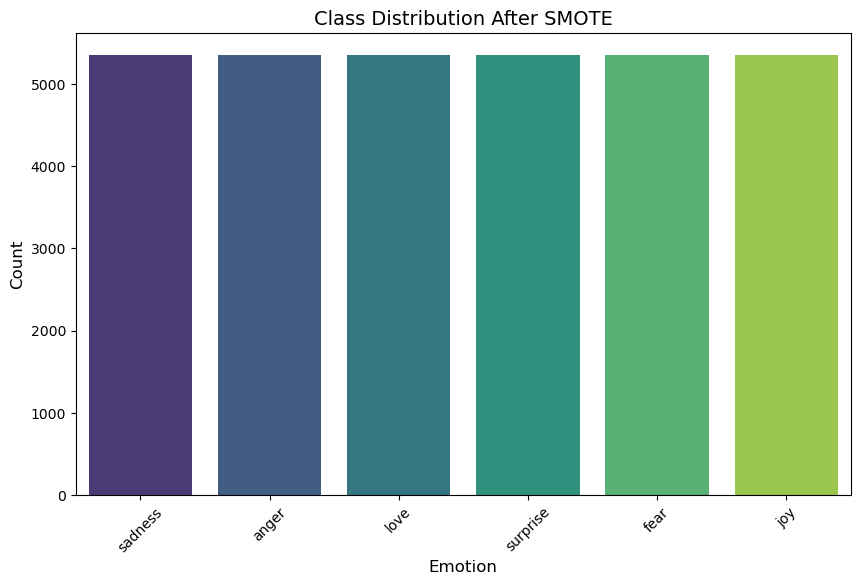

In [15]:
plt.figure(figsize=(10, 6))
sns.countplot(x=y_train_resampled, palette='viridis')
plt.title('Class Distribution After SMOTE', fontsize=14)
plt.xlabel('Emotion', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.show()

In [137]:
print(X_train_tfidf.shape)
print(X_train_resampled.shape)

(15969, 5000)
(32100, 5000)
[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]]


In [17]:
# Scaling
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train_resampled_dense)

X_test_scaled = scaler.transform(X_test_tfidf.toarray())
X_val_scaled = scaler.transform(X_val_tfidf.toarray())

## Logistic Regression

In [89]:
#Model 1 - Logistic Regression

# Define your parameter grid for logistic regression
param_grid_logistic_regression = {
    'C': [0.01, 0.1, 1, 10],
    'max_iter': [100, 200, 500]
}
# Perform grid search with cross-validation
grid_search_logistic_regression = GridSearchCV(LogisticRegression(), param_grid_logistic_regression, cv=5, scoring='accuracy')
grid_search_logistic_regression.fit(X_train_scaled, y_train_resampled)

# Get the best model from grid search
best_model_logistic_regression = grid_search_logistic_regression.best_estimator_

# Print the best model and parameters
print("Best Model:", best_model_logistic_regression)

Best Model: LogisticRegression(C=0.01)


In [139]:
log_reg_model = LogisticRegression(C=0.01, max_iter=100)

log_reg_model.fit(X_train_scaled, y_train_resampled)

# Now use the scaled data for predictions
y_pred_logistic_regression_test = log_reg_model.predict(X_test_scaled)
y_pred_logistic_regression_val = log_reg_model.predict(X_val_scaled)

y_pred_logistic_regression_test_encoded = label_encoder.transform(y_pred_logistic_regression_test)
y_pred_logistic_regression_val_encoded = label_encoder.transform(y_pred_logistic_regression_val)

Accuracy of Logistic Regression on TEST: 78.00%
Accuracy of Logistic Regression on VAL: 79.23%

Classification Report for Logistic Regression on TEST:

              precision    recall  f1-score   support

           0       0.75      0.75      0.75       275
           1       0.65      0.68      0.66       224
           2       0.84      0.84      0.84       695
           3       0.64      0.66      0.65       159
           4       0.84      0.82      0.83       581
           5       0.61      0.59      0.60        66

    accuracy                           0.78      2000
   macro avg       0.72      0.72      0.72      2000
weighted avg       0.78      0.78      0.78      2000



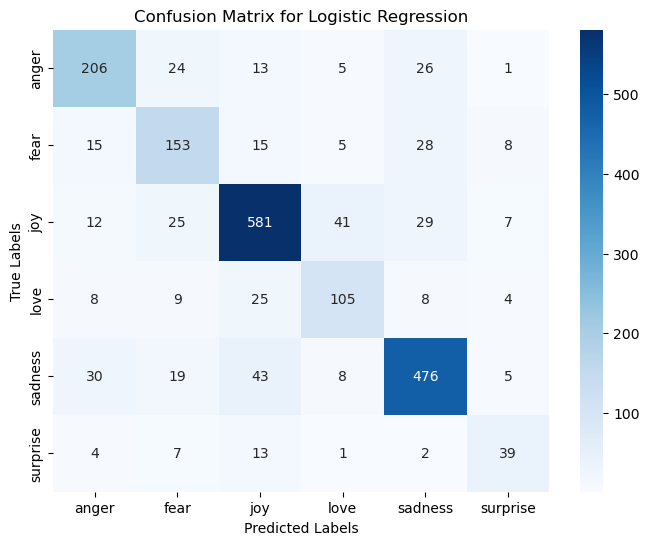

In [140]:
evaluate_model_and_visualize("Logistic Regression", y_test_encoded, y_val_encoded, y_pred_logistic_regression_test_encoded, y_pred_logistic_regression_val_encoded)

In [141]:
pickle_file = "log_reg_model.pkl"
with open(pickle_file, 'wb') as file:
    pickle.dump(log_reg_model, file)

## Random Forest

In [ ]:
# Model 2 - Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}
grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train_tfidf, y_train_encoded)
best_model_rf = grid_search_rf.best_estimator_

In [143]:
rf_model = RandomForestClassifier(n_estimators=500, max_depth=15, min_samples_split=10)

rf_model.fit(X_train_scaled, y_train_resampled)

# Now use the scaled data for predictions
y_pred_rf_test = rf_model.predict(X_test_scaled)
y_pred_rf_val = rf_model.predict(X_val_scaled)

y_pred_rf_test_encoded = label_encoder.transform(y_pred_rf_test)
y_pred_rf_val_encoded = label_encoder.transform(y_pred_rf_val)

Accuracy of Random Forest on TEST: 81.80%
Accuracy of Random Forest on VAL: 83.83%

Classification Report for Random Forest on TEST:

              precision    recall  f1-score   support

           0       0.87      0.82      0.84       275
           1       0.89      0.78      0.83       224
           2       0.83      0.82      0.82       695
           3       0.64      0.91      0.75       159
           4       0.89      0.80      0.84       581
           5       0.54      0.95      0.69        66

    accuracy                           0.82      2000
   macro avg       0.78      0.84      0.80      2000
weighted avg       0.83      0.82      0.82      2000



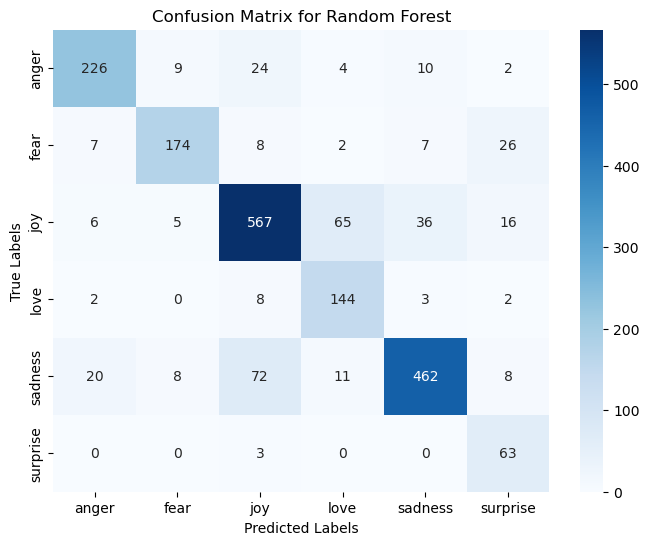

In [144]:
evaluate_model_and_visualize("Random Forest", y_test_encoded, y_val_encoded, y_pred_rf_test_encoded, y_pred_rf_val_encoded)

In [145]:
pickle_file = "rf_model.pkl"
with open(pickle_file, 'wb') as file:
    pickle.dump(rf_model, file)

## SVM

In [ ]:
# Model 3 - SVM
param_grid_svm = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['linear'],
    'gamma': ['scale', 'auto', 0.1, 0.01]
}

grid_search_svm = GridSearchCV(SVC(), param_grid_svm, cv=3, scoring='accuracy')
grid_search_svm.fit(X_train_tfidf, y_train_encoded)
best_model_svm = grid_search_svm.best_estimator_

In [ ]:
svm_model = SVC(C=1, kernel="linear", gamma="scale")

svm_model.fit(X_train_scaled, y_train_resampled)

# Now use the scaled data for predictions
y_pred_svm_test = svm_model.predict(X_test_scaled)
y_pred_svm_val = svm_model.predict(X_val_scaled)

y_pred_svm_test_encoded = label_encoder.transform(y_pred_svm_test)
y_pred_svm_val_encoded = label_encoder.transform(y_pred_svm_val)

In [ ]:
evaluate_model_and_visualize("SVM", y_test_encoded, y_val_encoded, y_pred_svm_test_encoded, y_pred_svm_val_encoded)

In [ ]:
pickle_file = "svm_model.pkl"
with open(pickle_file, 'wb') as file:
    pickle.dump(svm_model, file)

## Deep learning - LSTM

In [36]:
str_punc = string.punctuation.replace(',', '').replace("'",'')

def clean(text):
    global str_punc
    text = re.sub(r'[^a-zA-Z ]', '', text)
    text = text.lower()
    return text

X_train = train['Text'].apply(clean)
y_train = train['Emotion']

X_test = test['Text'].apply(clean)
y_test = test['Emotion']

X_val = val['Text'].apply(clean)
y_val = val['Emotion']

# Encode labels

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [37]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))


sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

X_train = pad_sequences(sequences_train, maxlen=200, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=200, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=200, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 16185


In [38]:
path_to_glove_file = 'glove.6B.200d.txt'
num_tokens = vocabSize
embedding_dim = 200
hits = 0
misses = 0
embeddings_index = {}

# Read word vectors
with open(path_to_glove_file, encoding="UTF-8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))


# Assign word vectors to our dictionary/vocabulary
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
Converted 15069 words (1115 misses)


In [24]:
adam = Adam(learning_rate=0.005)

model = Sequential()
model.add(Embedding(vocabSize, 200, weights=[embedding_matrix], trainable=False, input_length=X_train.shape[1]))
model.add(Bidirectional(LSTM(256, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2)))
model.add(Dense(6, activation='softmax'))

model.build(input_shape=(None, X_train.shape[1]))

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 200)          3237000   
                                                                 
 bidirectional (Bidirectiona  (None, 200, 512)         935936    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 200, 256)         656384    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 1542      
                                                        

In [25]:
callback = EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True,
)

In [26]:
# Fit model
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    batch_size=256,
                    epochs=10,
                    callbacks=[callback]
                   )


Epoch 1/10
63/63 [==============================] - 415s 6s/step - loss: 1.5896 - accuracy: 0.3480 - val_loss: 1.4068 - val_accuracy: 0.4860
Epoch 2/10
63/63 [==============================] - 404s 6s/step - loss: 1.2464 - accuracy: 0.5399 - val_loss: 1.0663 - val_accuracy: 0.5896
Epoch 3/10
63/63 [==============================] - 401s 6s/step - loss: 1.0475 - accuracy: 0.5963 - val_loss: 0.8373 - val_accuracy: 0.6747
Epoch 4/10
63/63 [==============================] - 393s 6s/step - loss: 0.7091 - accuracy: 0.7142 - val_loss: 0.5007 - val_accuracy: 0.8003
Epoch 5/10
63/63 [==============================] - 392s 6s/step - loss: 0.4066 - accuracy: 0.8540 - val_loss: 0.2481 - val_accuracy: 0.9129
Epoch 6/10
63/63 [==============================] - 397s 6s/step - loss: 0.2277 - accuracy: 0.9165 - val_loss: 0.1832 - val_accuracy: 0.9269
Epoch 7/10
63/63 [==============================] - 392s 6s/step - loss: 0.1609 - accuracy: 0.9339 - val_loss: 0.1688 - val_accuracy: 0.9269
Epoch 8/10
63

In [27]:
model.save('model_lstm.h5')

In [39]:
predicted = model.predict(X_test)
y_pred = predicted.argmax(axis=-1)

print(classification_report(le.transform(test['Emotion']), y_pred))

63/63 [==============================] - 21s 340ms/step
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       275
           1       0.90      0.88      0.89       224
           2       0.91      0.96      0.93       695
           3       0.88      0.68      0.77       159
           4       0.97      0.95      0.96       581
           5       0.71      0.85      0.77        66

    accuracy                           0.92      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.92      0.92      0.92      2000



In [40]:
# Visualize Loss & Accuracy

%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

NameError: name 'history' is not defined

# Analysing models + SHAP/LIME

## Linear Regression

In [165]:
explainer = shap.Explainer(log_reg_model, X_train_scaled, feature_names=vectorizer.get_feature_names_out())
shap_values = explainer(X_test_scaled)

Class anger SHAP values shape: (2000, 5000)


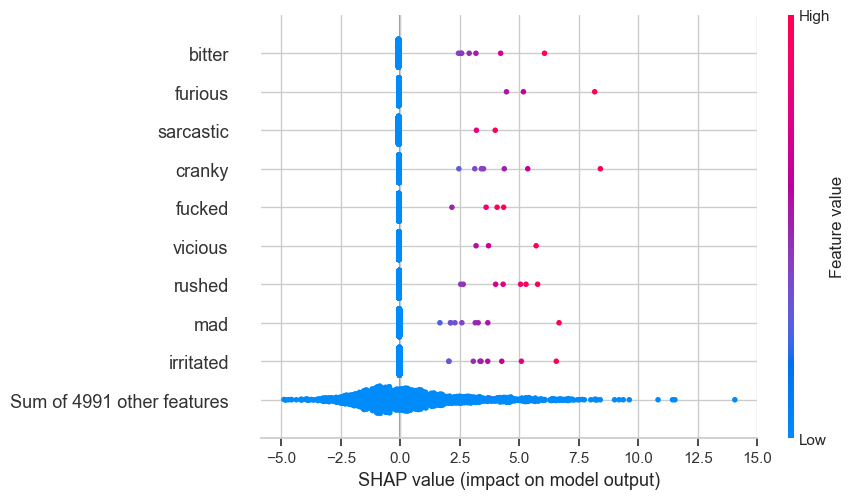

Class fear SHAP values shape: (2000, 5000)


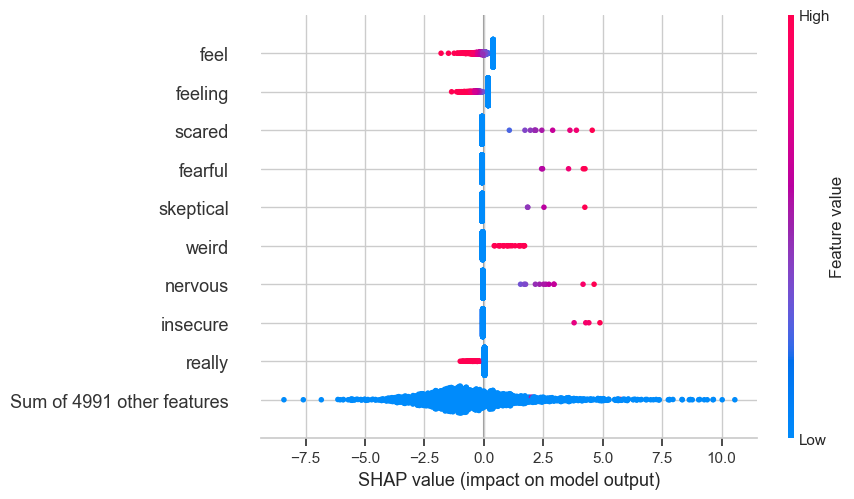

Class joy SHAP values shape: (2000, 5000)


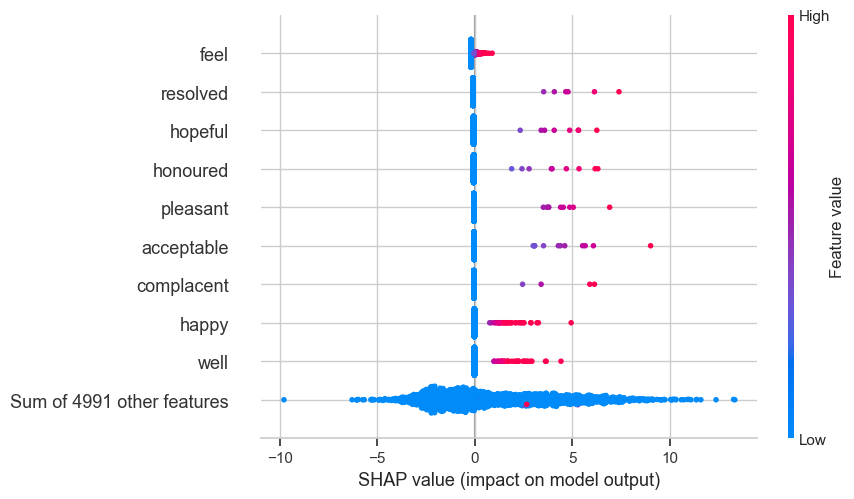

Class love SHAP values shape: (2000, 5000)


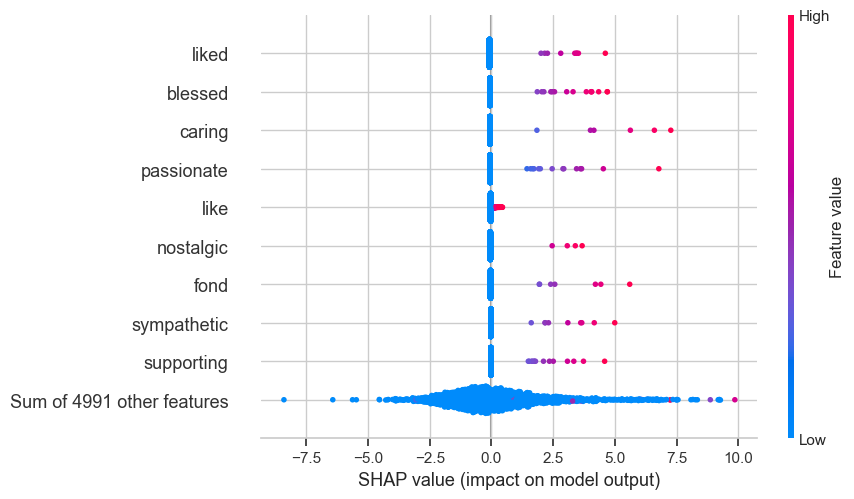

Class sadness SHAP values shape: (2000, 5000)


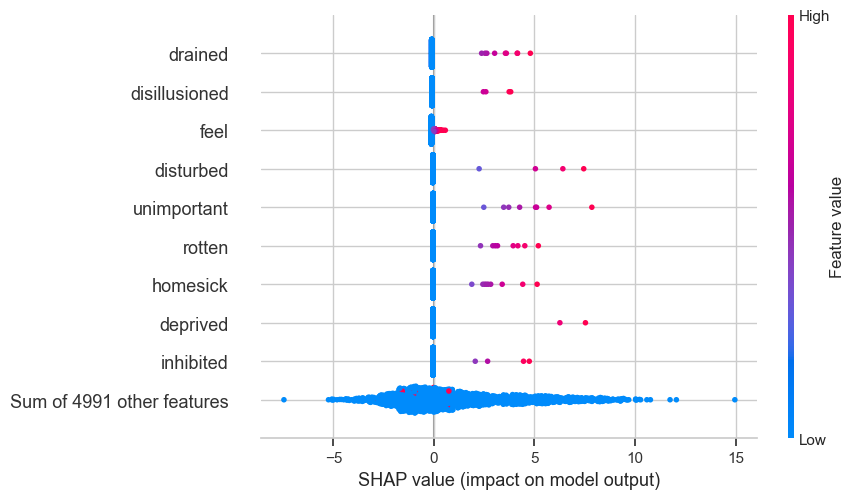

Class surprise SHAP values shape: (2000, 5000)


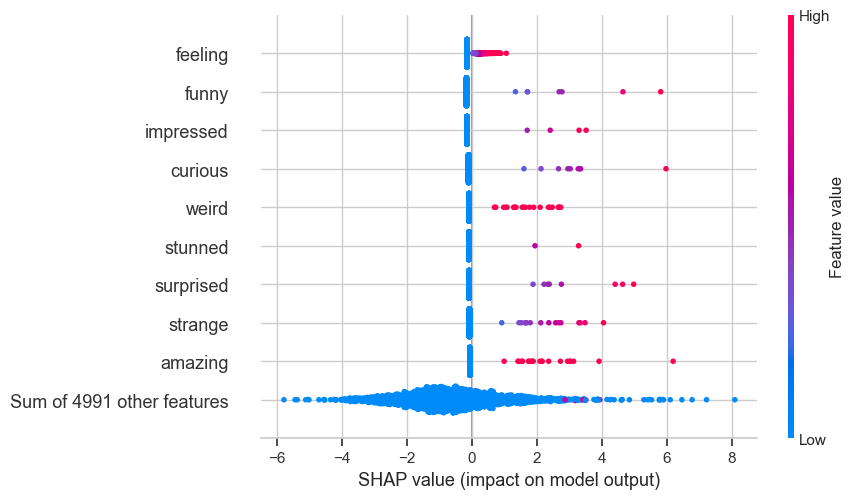

In [166]:
shap_values = explainer(X_test_scaled)
class_labels = ["anger", "fear", "joy", "love", "sadness", "surprise"]

# Iterate over classes and plot SHAP values
for class_index in range(shap_values.values.shape[2]):
    shap_class_values = shap_values[..., class_index]
    print(f"Class {class_labels[class_index]} SHAP values shape: {shap_class_values.shape}")
    shap.plots.beeswarm(shap_class_values)


## LSTM

In [134]:
# Function to preprocess text and return predictions
def predict_proba(texts):
    texts_vector = tokenizer.texts_to_sequences(texts)
    padded_texts = pad_sequences(texts_vector, maxlen=200, truncating='pre')
    return model.predict(padded_texts)

# Initialize LIME text explainer with all class names
explainer = LimeTextExplainer(class_names=['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'])

# Example text to explain
text = "I can't do it, I'm not ready to lose anything, just leave me alone"

# Ensure the text is cleaned appropriately for the model
cleaned_text = clean(text)
print(f"Cleaned text: {cleaned_text}")

# Generate LIME explanation
exp = explainer.explain_instance(cleaned_text, predict_proba, num_features=10, top_labels=6)

# Visualize LIME explanation
exp.show_in_notebook(text=True)

Cleaned text: i cant do it im not ready to lose anything just leave me alone
157/157 [==============================] - 53s 336ms/step
